## 使用均方范数作为硬性限制
* 通过限制参数值的选择范围来控制模型容量(通常限制w)



## 使用均方范数作为柔性限制
* 对于每个 $\theta$，都可以找到$\lambda$使得之前的目标函数等价于(增加一个罚项)   
$ min \tau(w,b)+\lambda/2||w||^2 $  
* 超参数 $\lambda$控制了正则项的重要程度  
    * $\lambda=0$:无作用  
    
    * $\lambda->\infty, w->0 $

## 参数更新法则
(推导见课本)  
* 通常$\eta\lambda$<1，在深度学习中叫做权重衰退

## 从0实现

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


In [5]:
# n_train:训练集大小 n_test:测试集大小 num_inputs:模型参数大小 batch_size：批量大小
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1))*0.01, 0.05
print(true_w.shape)
# synthetic_data 取n_train个0~1的x计算y
train_data = d2l.synthetic_data(true_w, true_b, n_train)
print(train_data[0].shape)
print(train_data[1].shape)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter =d2l.load_array(test_data, batch_size, is_train=True)

torch.Size([200, 1])
torch.Size([20, 200])
torch.Size([20, 1])


In [6]:
def init_params():
    w = torch.normal(0, 1,size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义L2范数惩罚

In [7]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [8]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # with torch.enable_grad():
            # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())


w的L2范数是： 13.465778350830078


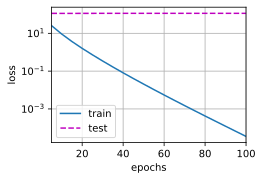

In [9]:
train(lambd=0)

w的L2范数是： 0.016571611166000366


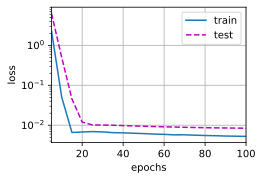

In [10]:
train(lambd=20)

## 简洁实现

In [13]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    updater = torch.optim.SGD([
        {"params":net[0].weight,
         "weight_decay":wd},
        {"params":net[0].bias}
    ],lr =lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            updater.zero_grad()
            l = loss(net(X), y)
            l.backward()
            updater.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())
    

w的L2范数： 0.33691346645355225


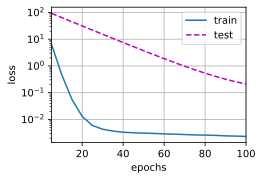

In [14]:
train_concise(3)